## PreProcess Images and feed into CNN

In [22]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [23]:
# Install package to handle .tiff data
!pip install pyrsgis

In [24]:
# Clone my git repo for preprocessing the images

!git clone https://github.com/maxjonasbehrens/master_thesis_code
#%cd /content/master_thesis_code
#!git pull

fatal: destination path 'master_thesis_code' already exists and is not an empty directory.


In [0]:
# Load Python script for preprocessing
%load /content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py

In [0]:
# Load necessary packages
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io
import sklearn.model_selection
import imageio

In [0]:
# Import own module to preprocess images
import imp
sat_images = imp.new_module('sat_images')
exec(open("/content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py").read(), sat_images.__dict__)

## Test for one image

In [0]:
# Download test image from drive
img_path = "/gdrive/My Drive/ThesisData/training/day/AL02_3900.0_2011.png"

img = imageio.imread(img_path)

In [0]:
# Print its shape
print("Image shape: ",img.shape)

Image shape:  (1124, 1624, 3)


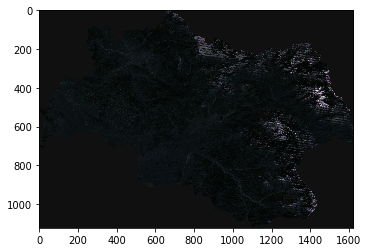

In [0]:
# Show the original image
plt.imshow(img, interpolation='nearest')
plt.show()

# Create input data

In [0]:
# Load Data Frame of NUTS regions and corresponding gdp values
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
y_dat.head()

,nuts2,year,nuts_value,code,country,country_value,mean_value,diff_value
0,BE10,2008,61100.0,BE,Belgium,33100.0,31881.818182,28000.0
1,BE21,2008,39200.0,BE,Belgium,33100.0,31881.818182,6100.0
2,BE22,2008,27500.0,BE,Belgium,33100.0,31881.818182,-5600.0
3,BE23,2008,29400.0,BE,Belgium,33100.0,31881.818182,-3700.0
4,BE24,2008,34500.0,BE,Belgium,33100.0,31881.818182,1400.0


In [0]:
# Benchmark for diff-value (other benchmark are in other script)
mae_diff = np.mean(abs(y_dat['diff_value']-y_dat['diff_value'].mean()))
print(mae_diff)

5478.004371660496


In [0]:
# List of all files in directory of images
mypath = "/gdrive/My Drive/nuts_day_raw/"
mypath_day = "/gdrive/My Drive/nuts_geotiff/"
sat_images.create_save_data(mypath,y_dat,prediction='nuts_value',kind='subsample',resolution=128,night=True)

## Sample CNN Architectures

In [0]:
# Very shallow CNN
model = Sequential()
model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(units=out_shape,activation='relu'))

In [0]:
# Fully connected model
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(out_shape, activation='relu'))

In [0]:
# Deep Model
model = Sequential()

model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu',activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(units=out_shape,activation='relu'))

In [0]:
# Shallow Model
model = tf.keras.Sequential()

model.add(Conv2D(16, 3, padding='same', input_shape=in_shape, activation='relu'))
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='normal', activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(units=out_shape, kernel_initializer='normal',activation='relu'))

In [0]:
# Transfer Learning
base_model = ResNet50(input_shape=in_shape,include_top=False)
	x=base_model.output
	x=Flatten()(x)
	x=Dense(32,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
	x=Dropout(0.2)(x) #Dropout
	x=Dense(32,activation='relu')(x) #dense layer 3
	x=Dropout(0.2)(x) #Dropout
	preds=Dense(units=out_shape, activation = 'relu')(x)
	model=Model(inputs=base_model.input,outputs=preds)
 
	for layer in model.layers[:156]:
  	layer.trainable = False


94658560/94653016 [==============================] - 7s 0us/step


In [0]:
# dense layers much less

# Training Pipeline for CNN Fitting

In [0]:
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import SGD, Adam
from keras.applications import VGG16, ResNet50, ResNet50V2, InceptionResNetV2
from keras.callbacks import EarlyStopping
import scipy
import pandas as pd
import numpy as np
from datetime import date
from os import listdir
from os.path import isfile, join, getsize

In [0]:
# Create DataFrame to load the data
def data_load(data_type):
  
  train_path = "/gdrive/My Drive/ThesisData/training/"+str(data_type)+"/"
  val_path = "/gdrive/My Drive/ThesisData/validation/"+str(data_type)+"/"
  test_path = "/gdrive/My Drive/ThesisData/test/"+str(data_type)+"/"

  train_files = [f for f in listdir(train_path) if isfile(join(train_path, f)) and getsize(join(train_path, f)) > 0]
  val_files = [f for f in listdir(val_path) if isfile(join(val_path, f)) and getsize(join(val_path, f)) > 0]
  test_files = [f for f in listdir(test_path) if isfile(join(test_path, f)) and getsize(join(test_path, f)) > 0]

  train_y = [float(img.rsplit('_')[1]) for img in train_files]
  val_y = [float(img.rsplit('_')[1]) for img in val_files]
  test_y = [float(img.rsplit('_')[1]) for img in test_files]

  train_df = pd.DataFrame({'y':train_y,'file':train_files})
  val_df = pd.DataFrame({'y':val_y,'file':val_files})
  test_df = pd.DataFrame({'y':test_y,'file':test_files})

  return train_df, val_df, test_df

In [0]:
# define cnn model
def define_model(lr,in_shape=(512, 512, 3), out_shape=1):
	
	# Very shallow CNN
	model = Sequential()
	model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
	#model.add(BatchNormalization())
	#model.add(MaxPooling2D(pool_size=(2,2)))
	model.add(Flatten())
	#model.add(Dense(256, activation='relu'))
	#model.add(Dropout(0.5))
	model.add(Dense(units=out_shape,activation='relu'))
	
	# compile model
	opt = Adam(lr=lr)
	model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse','mae'])
 
	return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history,no_layers,in_shape,batch_size,epochs,mse,mae,transfer,lr,optim,comment,data_type):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Model MSE')
	pyplot.plot(history.history['mean_squared_error'], color='blue', label='train')
	pyplot.plot(history.history['val_mean_squared_error'], color='orange', label='val')
	pyplot.xlabel("")
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Model MAE')
	pyplot.plot(history.history['mean_absolute_error'], color='blue', label='train')
	pyplot.plot(history.history['val_mean_absolute_error'], color='orange', label='val')
	# save plot to file
	day = date.today()
	filename = str(day)+"_"+str(in_shape[0])+"_"+str(in_shape[2])+"_"+str(epochs)+"_"+str(batch_size)
	pyplot.savefig('/gdrive/My Drive/ThesisData/cnn_results/'+filename + '_plot.png')
	pyplot.close()
  
	# write diagnostics to results file
	myrow = ['\n'+str(day),str(no_layers),str(batch_size),str(epochs),str(in_shape[0]),str(in_shape[2]),
	         str(history.history['mean_squared_error'][-1]),str(history.history['mean_absolute_error'][-1]),
					     str(history.history['val_mean_squared_error'][-1]),str(history.history['val_mean_absolute_error'][-1]),
							   str(mse),str(mae),str(transfer),str(lr),str(optim),str(comment),str(data_type)]
	myrow = ','.join(myrow)
	filepath = '/gdrive/My Drive/ThesisData/cnn_results/cnn_results.csv'
	with open(filepath,'a') as fd:
		fd.write(myrow)

In [0]:
# run the test harness for evaluating a model
def run_test_harness(comment,transfer,optim,data_type,lr=0.0001,batch_size = 10,epochs = 50, target_size = 128):
  
  # load dataset
  train_df, val_df, test_df = data_load(data_type=data_type)
  
  # create data generator
  train_datagen = ImageDataGenerator(rescale=(1.0/256), horizontal_flip=True, vertical_flip=True, rotation_range=90)
  val_datagen = ImageDataGenerator(rescale=(1.0/256))
  test_datagen = ImageDataGenerator(rescale=(1.0/256))

  # Define early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20, restore_best_weights=True)

  # File Directories
  train_path = "/gdrive/My Drive/ThesisData/training/"+str(data_type)
  val_path = "/gdrive/My Drive/ThesisData/validation/"+str(data_type)
  test_path = "/gdrive/My Drive/ThesisData/test/"+str(data_type)

  # Infer color mode and input shape
  if data_type == 'day' or data_type == 'night' or data_type == 'subsample':
    color_mode = 'rgb'
    in_shape = (target_size,target_size,3)
  else:
    color_mode = 'rgba'
    in_shape = (target_size,target_size,4)

  # prepare iterators
  train_it = train_datagen.flow_from_dataframe(train_df,
                                               directory=train_path,
                                               x_col = 'file',
                                               y_col = 'y',
                                               target_size = (target_size,target_size),
                                               batch_size = batch_size,
                                               class_mode = 'raw',
                                               color_mode = color_mode)
  val_it = val_datagen.flow_from_dataframe(val_df, 
                                           directory=val_path,
                                           x_col = 'file',
                                           y_col = 'y',
                                           target_size = (target_size,target_size),
                                           batch_size = batch_size,
                                           class_mode = 'raw',
                                           color_mode = color_mode)
  test_it = test_datagen.flow_from_dataframe(test_df, 
                                             directory=test_path,
                                             x_col = 'file',
                                             y_col = 'y',
                                             target_size = (target_size,target_size),
                                             batch_size = batch_size,
                                             class_mode = 'raw',
                                             color_mode = color_mode)
  
  # define model
  model = define_model(lr=lr,in_shape=in_shape)
  no_layers = len(model.layers)
  
  # fit model
  history = model.fit_generator(train_it, 
                                steps_per_epoch=len(train_it),
                                validation_data=val_it, 
                                validation_steps=len(val_it),
                                callbacks = [es], 
                                epochs=epochs, 
                                verbose=2)
  
  # evaluate model
  loss, mse, mae = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
  print('> mse=%.3f, mae=%.3f' % (mse, mae))
  
  # learning curves
  summarize_diagnostics(history=history,
                        no_layers=no_layers,
                        in_shape = in_shape,
                        batch_size=batch_size,
                        epochs=len(history.history['loss']),
                        mse=mse,mae=mae,
                        transfer=transfer,lr=lr,
                        optim=optim,
                        comment=comment,
                        data_type=data_type)

In [57]:
run_test_harness("very shallow - one FC","no","adam",data_type='night',lr=0.0001,batch_size=64,epochs=1000,target_size=64)

Found 372 validated image filenames.
Found 140 validated image filenames.
Found 180 validated image filenames.
Epoch 1/1000
 - 28s - loss: 682029435.9693 - mean_squared_error: 682029435.9693 - mean_absolute_error: 21890.9233 - val_loss: 542381856.9143 - val_mean_squared_error: 542381856.9143 - val_mean_absolute_error: 19624.1241
Epoch 2/1000
 - 28s - loss: 674595936.1475 - mean_squared_error: 674595936.1475 - mean_absolute_error: 21794.2111 - val_loss: 542185699.6571 - val_mean_squared_error: 542185699.6571 - val_mean_absolute_error: 19620.1471
Epoch 3/1000
 - 28s - loss: 682956753.0568 - mean_squared_error: 682956753.0568 - mean_absolute_error: 21911.7092 - val_loss: 541965605.4857 - val_mean_squared_error: 541965605.4857 - val_mean_absolute_error: 19615.6755
Epoch 4/1000
 - 28s - loss: 680671662.8940 - mean_squared_error: 680671662.8940 - mean_absolute_error: 21841.8355 - val_loss: 541715891.2000 - val_mean_squared_error: 541715891.2000 - val_mean_absolute_error: 19610.5891
Epoch 5/1

KeyboardInterrupt: ignored